## Deep Sequence Modeling Lab: Activity Recognition with RNNs, LSTMs, and GRUs

This lab explores different architectures for modeling sequential data in videos. We'll use the UCF-101 dataset with 5 classes for human activity recognition and compare the performance of:

1. Recurrent Neural Networks (RNNs)
2. Long Short-Term Memory networks (LSTMs)
3. Gated Recurrent Units (GRUs)

### 1. Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

**Device-agnostic code**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2. Data Loading and Visualization

**Dataset Preprocessing (UCF101 with 5 classes)**

In [3]:
# Use only 5 related classes for action recognition
SELECTED_CLASSES = ['Basketball', 'SoccerJuggling', 'TennisSwing', 'WalkingWithDog', 'JumpRope']

### Dataset class

In [16]:
class UCF101Dataset(Dataset):
    def __init__(self, root_dir, transform=None, sequence_length=16):
        self.root_dir = root_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.classes = [cls for cls in os.listdir(root_dir) if cls in SELECTED_CLASSES]
        self.data = []
        
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            videos = os.listdir(class_path)
            for video in videos:
                video_path = os.path.join(class_path, video)
                self.data.append((video_path, class_idx))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        video_path, class_idx = self.data[idx]
        frames = self._load_video(video_path)
        return frames, class_idx
    
    @staticmethod
    def _load_video(video_path, sequence_length=16):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []
        
        for i in range(sequence_length):
            frame_id = int(i * total_frames / sequence_length)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (224, 224))  # Adjust as per model input
                frames.append(frame)
        
        cap.release()
        video_tensor = torch.tensor(np.array(frames), dtype=torch.float32).permute(3, 0, 1, 2)  # (C, T, H, W)
        return video_tensor / 255.0  # Normalize

### Data preparation

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
# dataset directories
train_dir = "/kaggle/input/ucf101-action-recognition/train"
val_dir = "/kaggle/input/ucf101-action-recognition/val"
test_dir = "/kaggle/input/ucf101-action-recognition/test"

In [7]:
# Create dataset instances
train_dataset = UCF101Dataset(root_dir=train_dir, transform=transform)
val_dataset = UCF101Dataset(root_dir=val_dir, transform=transform)
test_dataset = UCF101Dataset(root_dir=test_dir, transform=transform)

In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [9]:
len(train_loader)

79

**Visualizing Random Samples from Dataset**

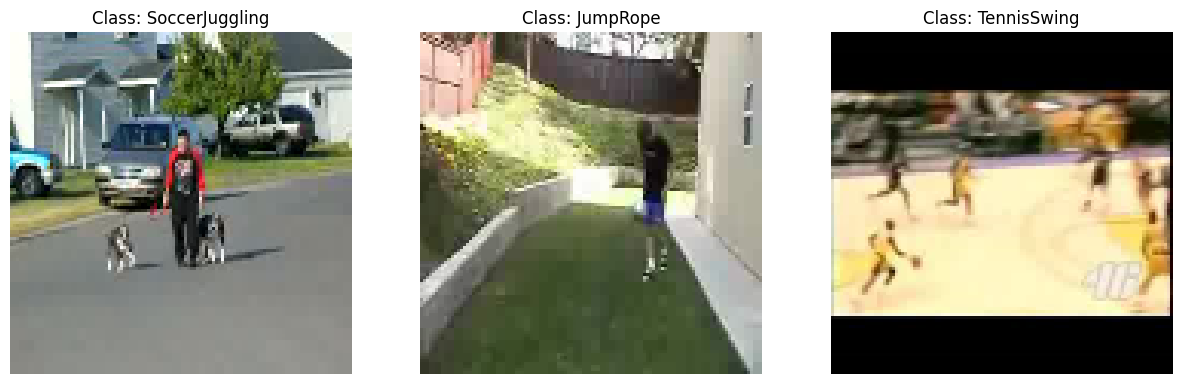

In [10]:
def show_random_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        frames, label = dataset[idx]
        frame = frames[:, 0, :, :].permute(1, 2, 0).numpy()  # Display the first frame
        axes[i].imshow(frame)
        axes[i].set_title(f"Class: {SELECTED_CLASSES[label]}")
        axes[i].axis('off')
    plt.show()

show_random_samples(train_dataset)

### 3. Models Training and Evaluation

#### **RNN Architecture**

In [132]:
# Define RNN-based model (CNN + RNN)
class CNN_RNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_RNN, self).__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 512)
        self.rnn = nn.RNN(512, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        batch_size, C, T, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).contiguous()  # (B, T, C, H, W)
        x = x.view(batch_size * T, C, H, W)
        x = self.cnn(x)  # (B*T, 512)
        x = x.view(batch_size, T, -1)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

In [133]:
# Initialize model, loss, and optimizer
model_rnn = CNN_RNN(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

**Training loop**

In [134]:
model_rnn.train_losses = []

epochs = 20
for epoch in range(epochs):
    model_rnn.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_rnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    model_rnn.train_losses.append(epoch_loss)  # Store epoch loss
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Epoch 1, Loss: 1.2668804028366185


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 2, Loss: 1.1978958173643184


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Epoch 3, Loss: 1.0816248994839341


100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 4, Loss: 1.07252608673482


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Epoch 5, Loss: 1.0940409800674342


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 6, Loss: 1.1736000897009162


100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 7, Loss: 1.1597994830034957


100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 8, Loss: 1.11453581988057


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 9, Loss: 1.0754147534128986


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 10, Loss: 1.0044392683083498


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 11, Loss: 1.1432308290578141


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 12, Loss: 1.0904504641701904


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 13, Loss: 0.9491451635390897


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 14, Loss: 1.037039783559268


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 15, Loss: 1.2111602848089194


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 16, Loss: 1.0143374781819838


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 17, Loss: 1.0574247086349922


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 18, Loss: 0.978226086761378


100%|██████████| 79/79 [00:38<00:00,  2.07it/s]


Epoch 19, Loss: 0.8641975344736365


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]

Epoch 20, Loss: 0.8194533179077921


**Evaluation**

In [140]:
model_rnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_rnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc_rnn = 100 * correct / total
print(f"Test Accuracy (RNN): {test_acc_rnn}%")

Test Accuracy (RNN): 71.29629629629629%


#### **LSTM-based model**

In [141]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_LSTM, self).__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Identity()
        self.lstm = nn.LSTM(512, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        batch_size, C, T, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(batch_size * T, C, H, W)
        x = self.cnn(x)
        x = x.view(batch_size, T, -1)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [137]:
# Initialize model, loss, and optimizer
model_lstm = CNN_LSTM(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

**Training loop**

In [138]:
model_lstm.train_losses = []

epochs = 20
for epoch in range(epochs):
    model_lstm.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    model_lstm.train_losses.append(epoch_loss)  # Store epoch loss
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 1, Loss: 1.2248469221441052


100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 2, Loss: 0.9636881555183024


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Epoch 3, Loss: 0.8636360051511209


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 4, Loss: 0.7966392719292943


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 5, Loss: 0.6254548081491567


100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 6, Loss: 0.5961493465907967


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 7, Loss: 0.5968783369547204


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 8, Loss: 0.44487081524692


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 9, Loss: 0.3408424559084675


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 10, Loss: 0.40551069081772734


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 11, Loss: 0.33114601303882235


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 12, Loss: 0.3105124826012533


100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 13, Loss: 0.3846850250906582


100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 14, Loss: 0.25507149423319325


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Epoch 15, Loss: 0.26071657495030875


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 16, Loss: 0.193257289349184


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 17, Loss: 0.32125470190768757


100%|██████████| 79/79 [00:38<00:00,  2.06it/s]


Epoch 18, Loss: 0.1715960633481228


100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


Epoch 19, Loss: 0.1982780861184944


100%|██████████| 79/79 [00:39<00:00,  2.01it/s]

Epoch 20, Loss: 0.13690594873756548


**Evaluation**

In [150]:
model_lstm.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_lstm(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc_lstm = 100 * correct / total
print(f"Test Accuracy (LSTM): {test_acc_lstm}%")

Test Accuracy (LSTM): 88.88888888888889%


#### **GRU Architecture**

In [11]:
class CNN_GRU(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_GRU, self).__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Identity()
        self.gru = nn.GRU(512, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        batch_size, C, T, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(batch_size * T, C, H, W)
        x = self.cnn(x)
        x = x.view(batch_size, T, -1)
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

In [12]:
# Initialize model, loss, and optimizer
model_gru = CNN_GRU(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gru.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


**Training loop**

In [13]:
model_gru.train_losses = []

epochs = 10
for epoch in range(epochs):
    model_gru.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_gru(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    model_gru.train_losses.append(epoch_loss)  # Store epoch loss
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


Epoch 1, Loss: 1.1956868201871462


100%|██████████| 79/79 [00:38<00:00,  2.04it/s]


Epoch 2, Loss: 1.0060354331626167


100%|██████████| 79/79 [00:40<00:00,  1.97it/s]


Epoch 3, Loss: 0.7359054154610332


100%|██████████| 79/79 [00:39<00:00,  1.98it/s]


Epoch 4, Loss: 0.7338447053975696


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 5, Loss: 0.5901613519350185


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]


Epoch 6, Loss: 0.47266108504956283


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 7, Loss: 0.3453999297999883


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 8, Loss: 0.32580283760458606


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Epoch 9, Loss: 0.3411218441928489


100%|██████████| 79/79 [00:38<00:00,  2.03it/s]

Epoch 10, Loss: 0.2180423540876636


**Evaluation**

In [14]:
model_gru.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_gru(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc_gru = 100 * correct / total
print(f"Test Accuracy (GRU): {test_acc_gru}%")

Test Accuracy (GRU): 86.11111111111111%


### 4. Comparison and Visualization

**Training Loss Comparison**

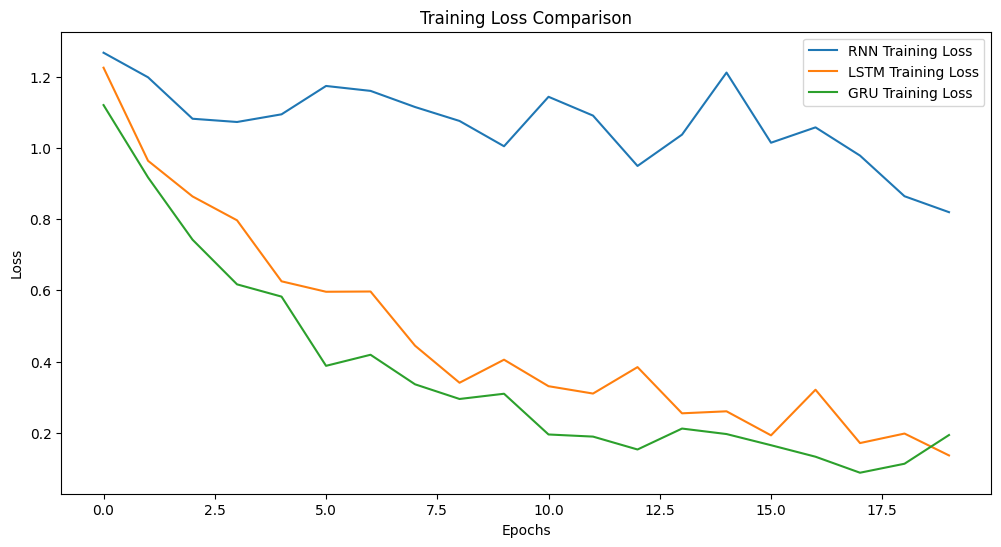

In [146]:
# Compare performance of all models
models_dict = {
    'RNN': model_rnn,
    'LSTM': model_lstm,
    'GRU': model_gru
}

# Plot accuracy and loss curves for each model
plt.figure(figsize=(12, 6))
for model_name, model in models_dict.items():
    plt.plot(model.train_losses, label=f"{model_name} Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

**Testing**

In [20]:
def predict_video(model, video_path, device):
    model.eval()
    video_frames = UCF101Dataset._load_video(video_path)  # No need to pass None
    video_frames = video_frames.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(video_frames)
        _, predicted_class = torch.max(output, 1)

    predicted_label = SELECTED_CLASSES[predicted_class.item()]
    print(f'Predicted Action: {predicted_label}')
    
    return predicted_label

# Example usage
video_path = "/kaggle/input/ucf101-action-recognition/test/SoccerJuggling/v_SoccerJuggling_g02_c01.avi"
predicted_action = predict_video(model_gru, video_path, device)

Predicted Action: SoccerJuggling


**Accuracy Comparison**

In [151]:
# Create DataFrame for results
results = {
    'Model': ['RNN', 'LSTM', 'GRU'],
    'Accuracy': [test_acc_rnn, test_acc_lstm, test_acc_gru]
}

In [152]:
df = pd.DataFrame(results)
print(df)

  Model   Accuracy
0   RNN  71.296296
1  LSTM  88.888889
2   GRU  94.444444


**Bar chart for accuracy comparison**

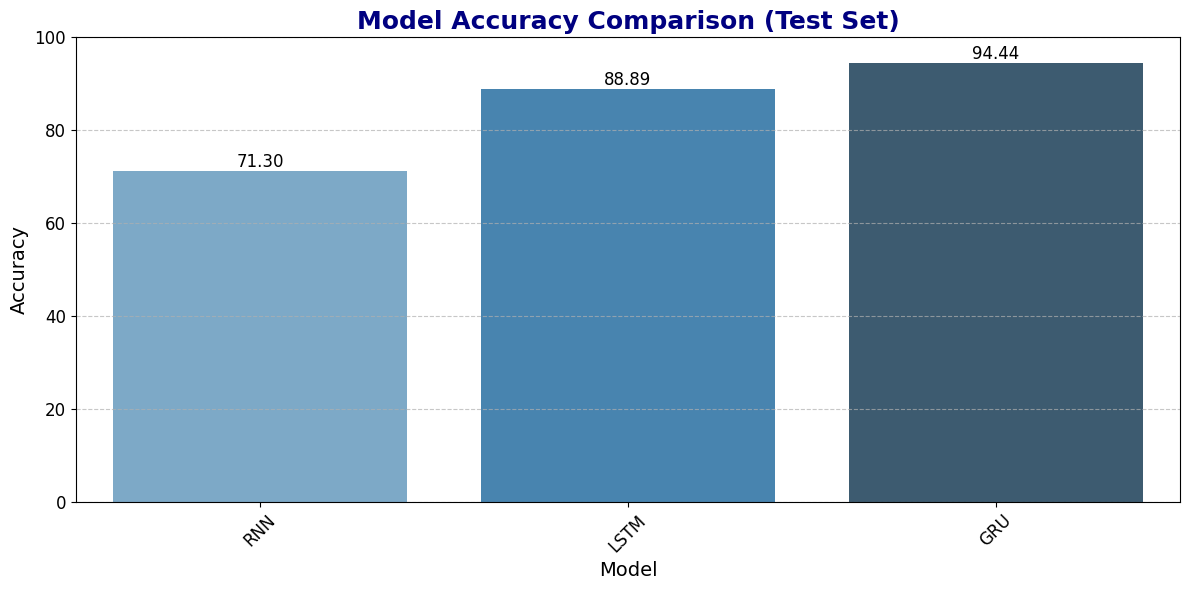

In [153]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Model', y='Accuracy', palette='Blues_d')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for index, value in enumerate(df['Accuracy']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=12)
plt.title('Model Accuracy Comparison (Test Set)', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.0, 100.0)
plt.tight_layout()
plt.show()

### 5. Save the best model

In [154]:
# Save the best model based on validation accuracy
best_model = model_gru
torch.save(best_model.state_dict(), "best_model.pth")
print("Best model saved as 'best_model.pth'")

Best model saved as 'best_model.pth'


### 6. State of the Art Models

### State-of-the-Art Models for Sequence Modeling:
1. **3D CNN**: C3D, I3D, SlowFast
2. **RNN**: ConvLSTM, PredRNN
3. **LSTM**: LRCN, Beyond Short Snippets
4. **GRU**: T-ConvGRU, Motion-Aware GRU